In [1]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
import malaya_speech
from malaya_speech import Pipeline
import IPython.display as ipd
warnings.filterwarnings("ignore")
from pysptk.sptk import rapt
import gc

1.8.0+cu111


# path

In [2]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# help functions

In [3]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80,hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel.T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    print('mel shape:',mel.shape)
    plt.show()

mel shape: (157, 80)


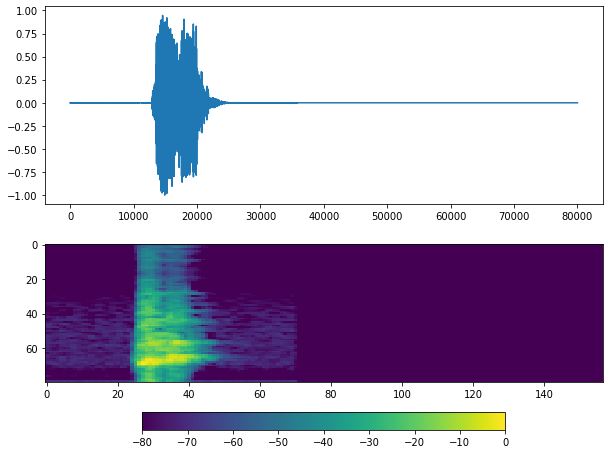

In [4]:
files = os.listdir(X_train_dir)
files.sort()
f = files[40]
y, sr = malaya_speech.load(X_train_dir+f)
plot(y,sr)
ipd.Audio(y, rate = sr)

# 取基頻

mel shape: (1, 80)


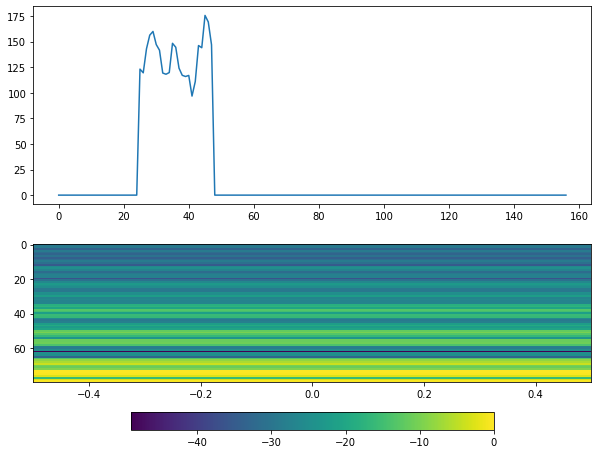

In [5]:
y_基頻 = rapt(y.astype('float32')*32767,sr,hopsize=512)
plot(y_基頻,sr)
ipd.Audio(y_基頻, rate = sr)

# 靜音部分消除

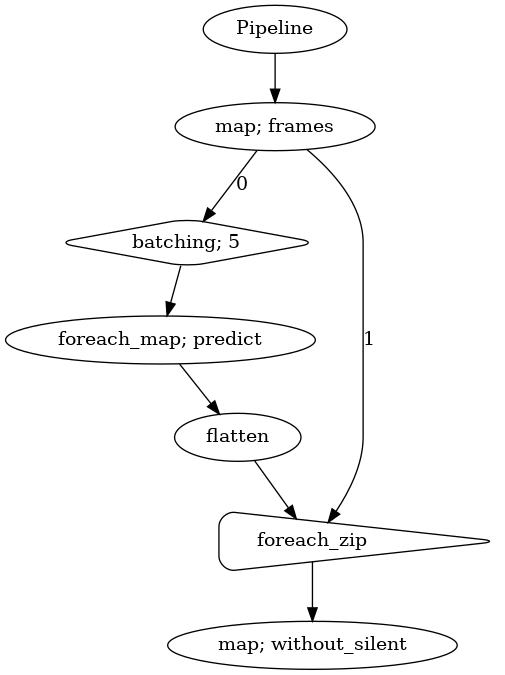

In [9]:
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent,
                                             threshold_to_stop = 0.05)

p.visualize()

In [10]:
def remove_silent(y,sr,time_length=80000):
    y =  p(y)['without_silent']
    if len(y) > time_length:
        y = y[0:0+time_length]
    else:
        y = np.pad(y, (0,time_length-len(y)))
    return y

mel shape: (157, 80)


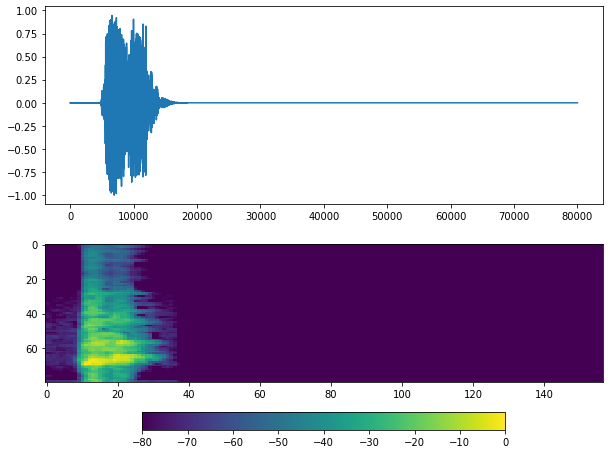

In [11]:
y_without_silent = remove_silent(y,sr)
plot(y_without_silent,sr)
ipd.Audio(y_without_silent, rate = sr)

# mel shape: (157, 80) #固定

# wav 2 features flow

In [12]:
def wav2featuresflow(y, sr):
    y_without_silent = remove_silent(y,sr)
    melspectrogram = np.rot90(norm_mel(y, sr))
    return melspectrogram

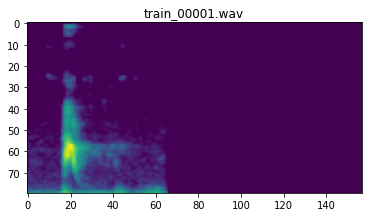

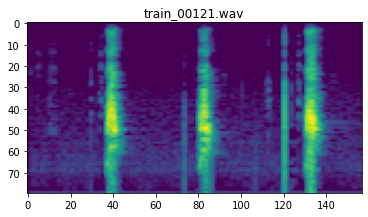

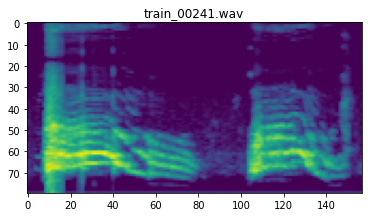

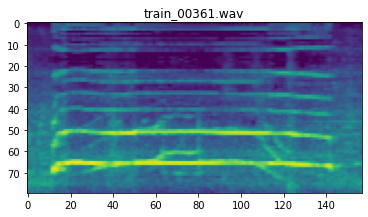

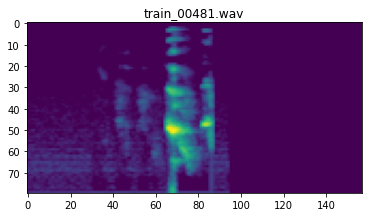

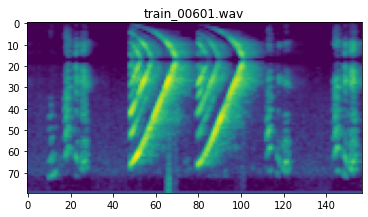

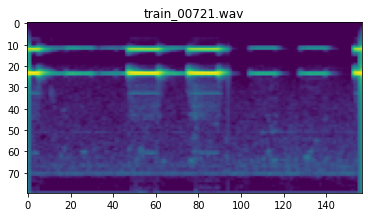

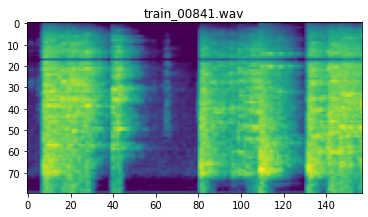

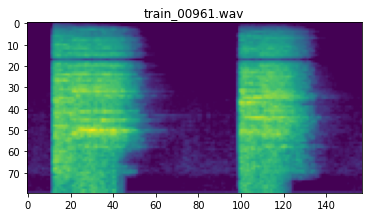

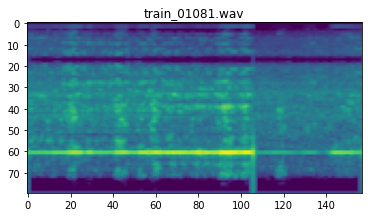

In [15]:
files = os.listdir(X_train_dir)
files.sort()
for f in files[::120]:
    y,sr = malaya_speech.load(X_train_dir+f)
    melspectrogram = wav2featuresflow(y,sr=16000)
    plt.imshow(melspectrogram)
    plt.title(f)
    plt.show()

# preprocessing 

In [16]:
def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            samples, sample_rate = malaya_speech.load(X_train_dir+f)
            melspectrogram = wav2featuresflow(samples,sr=sample_rate)
            melspectrogram = melspectrogram.reshape(-1,80,157).copy()
            melspectrogram = torch.from_numpy(melspectrogram)
            X = torch.cat([X,torch.unsqueeze(melspectrogram,0)],dim=0)
            gc.collect()
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path).iloc[:,:]
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

# Load X

In [109]:
#X_train = preprocessing_X(X_train_dir)
#torch.save(X_train,'X_train_吳啟聖教的方法.pt')

In [110]:
X_train = torch.load('X_train_吳啟聖教的方法.pt')

In [111]:
#X_test = preprocessing_X(X_test_dir)
#torch.save(X_test,'X_test_吳啟聖教的方法.pt')

In [112]:
X_test = torch.load('X_test_吳啟聖教的方法.pt')

In [113]:
gc.collect()

5324

In [114]:
X_train.shape,X_test.shape

(torch.Size([1199, 1, 80, 157]), torch.Size([10000, 1, 80, 157]))

# load Y

In [115]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Electrics'}

# look some sample

In [116]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

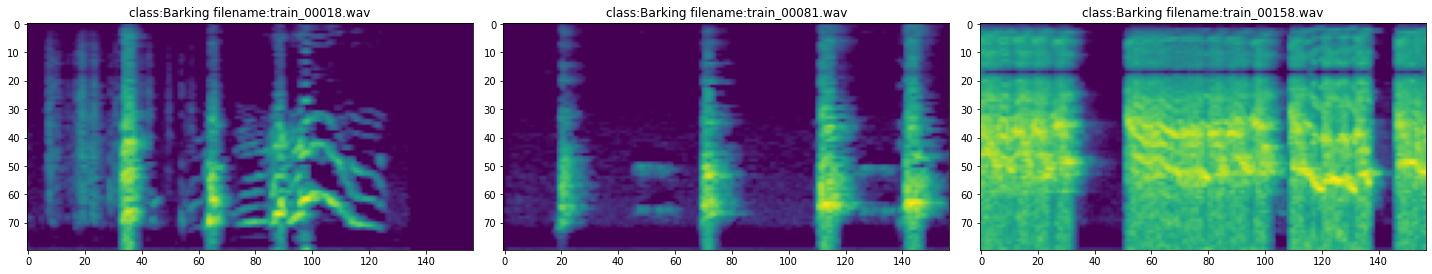

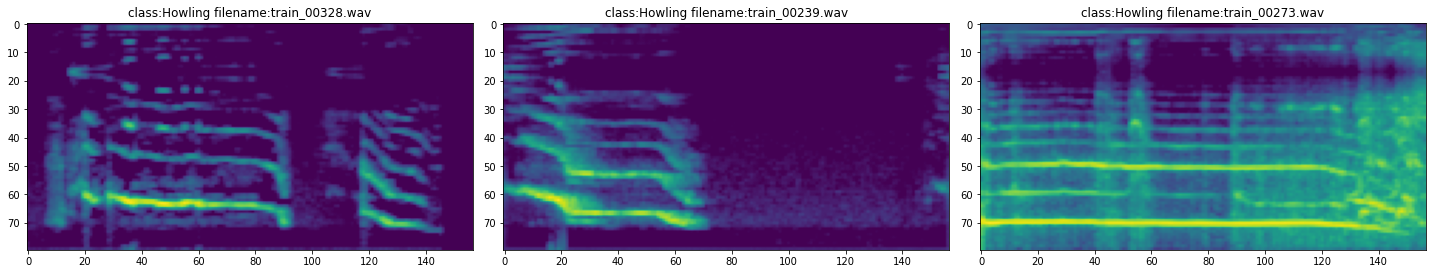

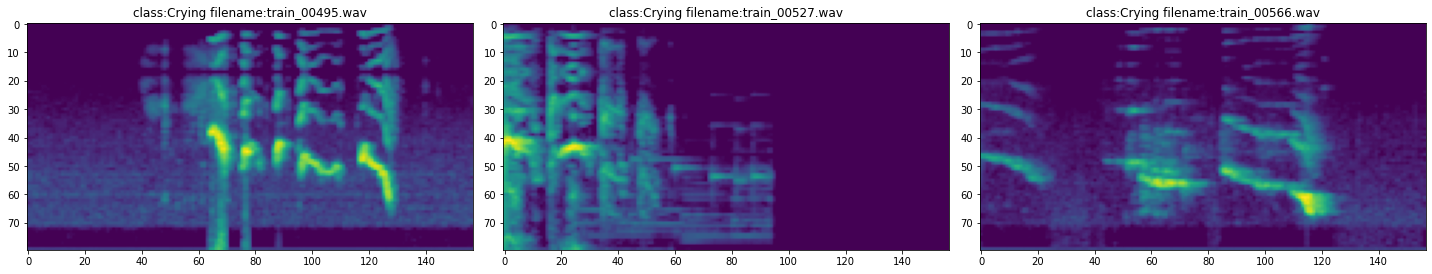

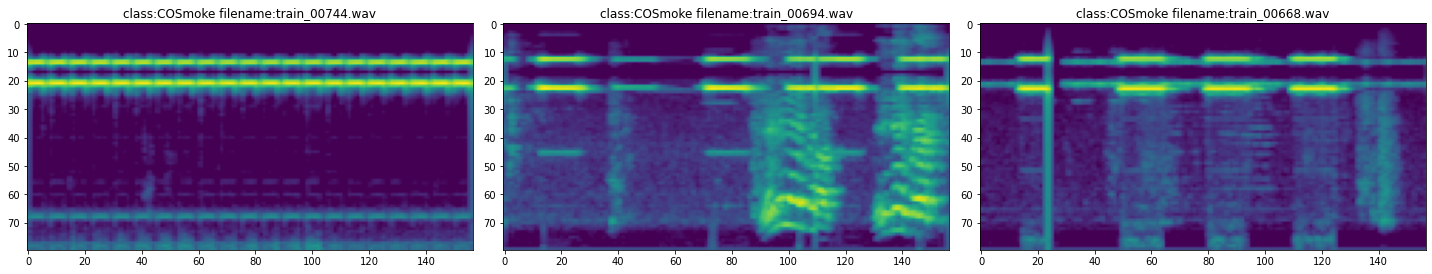

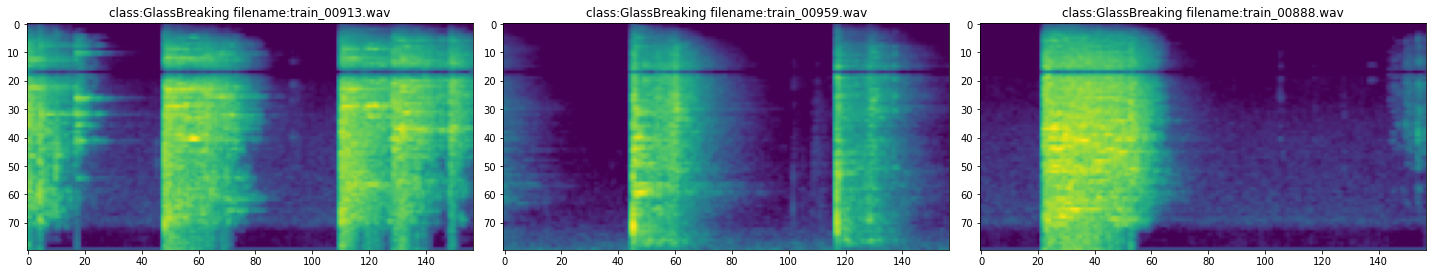

Other


<Figure size 1440x360 with 0 Axes>

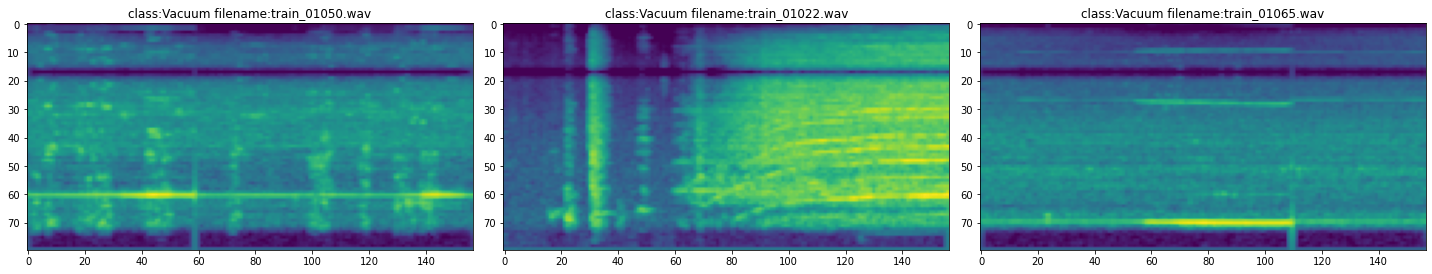

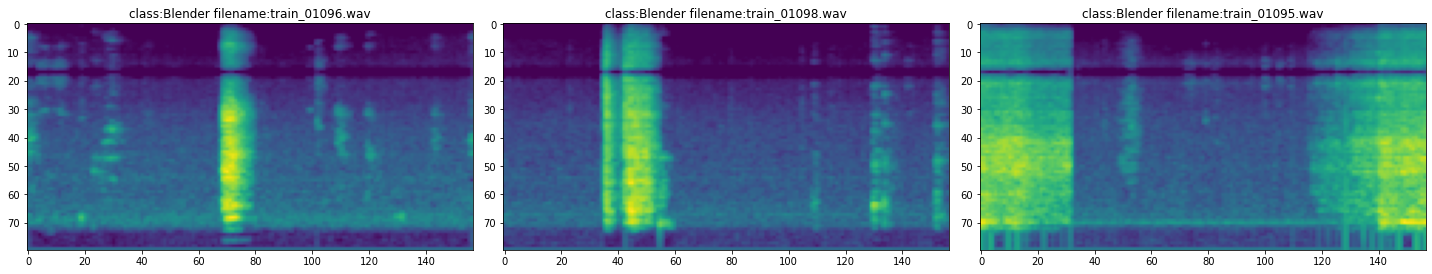

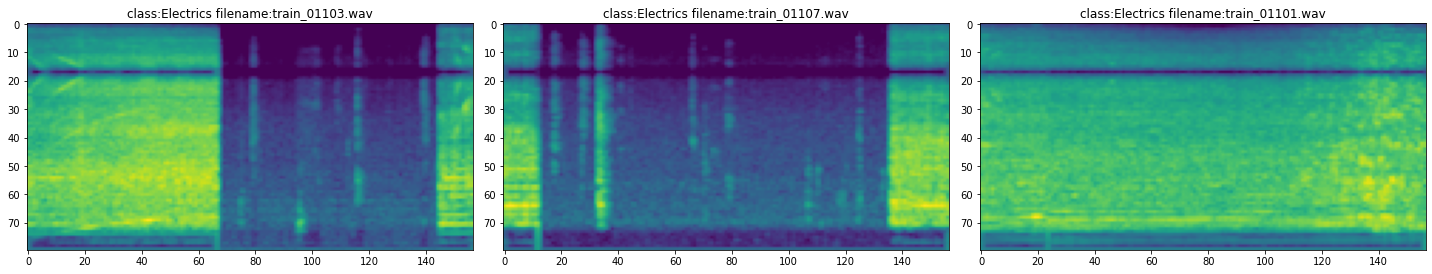

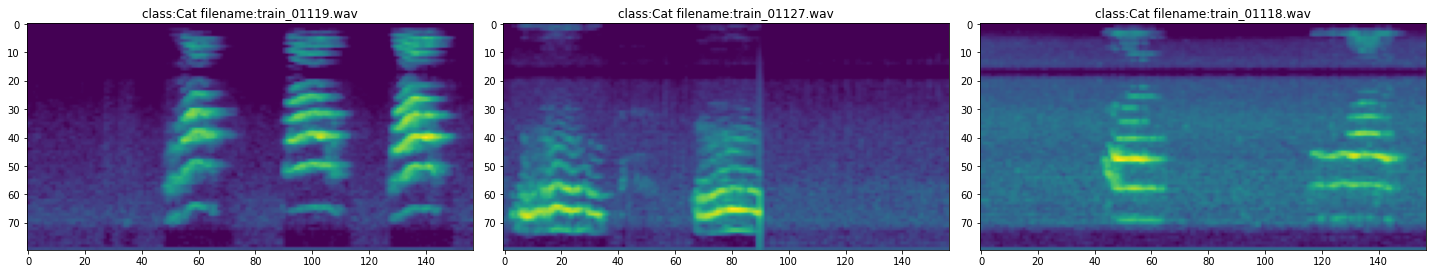

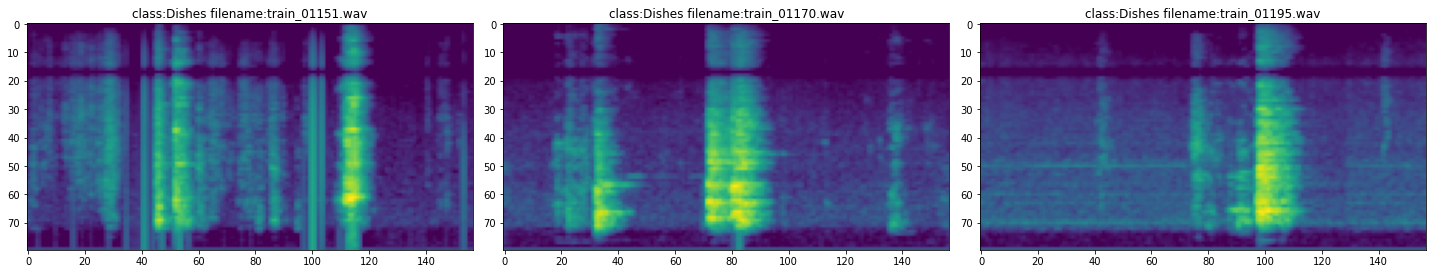

In [117]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42,stratify=Y_train)
print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([959, 1, 80, 157])
torch.Size([240, 1, 80, 157])
0    160
1    160
2    160
3    160
5    160
4    159
dtype: int64
0    40
1    40
2    40
3    40
4    40
5    40
dtype: int64


# 加入外部數據 to X_train

In [122]:
import joblib
expansion_data = joblib.load('expansion_data.pkl')
for k in expansion_data.keys():
    print(k,len(expansion_data[k]))

Electricssound 34
dogbarking 27
GlassBreakingsound 13
dogcrying 25
Vaccumsound 116
doghowling 18
dishessound 14
Catsound 24


In [123]:
expansion_data['Vaccumsound'] = expansion_data['Vaccumsound'][::4]

In [124]:
for k in expansion_data.keys():
    print(k,len(expansion_data[k]))

Electricssound 34
dogbarking 27
GlassBreakingsound 13
dogcrying 25
Vaccumsound 29
doghowling 18
dishessound 14
Catsound 24


In [125]:
class_idx_map_dict = {}
class_idx_map_dict['dogbarking'] = 0
class_idx_map_dict['doghowling'] = 1
class_idx_map_dict['dogcrying'] = 2
class_idx_map_dict['GlassBreakingsound'] = 4
class_idx_map_dict['Electricssound'] = 5
class_idx_map_dict['Vaccumsound'] = 5
class_idx_map_dict['dishessound'] = 5
class_idx_map_dict['Catsound'] = 5

In [126]:
def create_label(batch_size,length=6,class_idx=0):
    y = torch.tensor([[class_idx] for _ in range(batch_size)])
    y_onehot = torch.zeros([batch_size, length])
    return y_onehot.scatter_(1, y, 1)

extra_X_train = torch.FloatTensor([])
extra_y_train = torch.FloatTensor([])
data_idx = {}
for class_name in tqdm(expansion_data.keys()):
    data = expansion_data[class_name][::2]
    label = create_label(batch_size=len(data),length=6,class_idx=class_idx_map_dict[class_name])
    extra_X_train = torch.cat([extra_X_train,data],dim=0)
    extra_y_train = torch.cat([extra_y_train,label],dim=0)
extra_X_train.shape,extra_y_train.shape

100%|██████████| 8/8 [00:00<00:00, 346.68it/s]


(torch.Size([94, 1, 80, 157]), torch.Size([94, 6]))

In [127]:
print(expansion_data.keys())

dict_keys(['Electricssound', 'dogbarking', 'GlassBreakingsound', 'dogcrying', 'Vaccumsound', 'doghowling', 'dishessound', 'Catsound'])


# 檢視外部數據

In [128]:
extra_label_df = pd.DataFrame(extra_y_train.argmax(axis=1).detach().numpy(),columns = ['class_name'])
extra_label_df

class_name
0            5
1            5
2            5
3            5
4            5
..         ...
89           5
90           5
91           5
92           5
93           5

[94 rows x 1 columns]

In [129]:
def plot_feature_by_class_name(class_name,X,label_df):
    plt.figure(figsize=(20,5))
    i = 0
    for idx,file_idx in enumerate(label_df[label_df.class_name==class_name].sample(3).index):
        feature = X[int(file_idx)]
        plt.subplot(1,3,i+1)
        plt.imshow(feature[0,:,:])
        title = 'class:{} file_idx:{}'.format(class_name,file_idx)
        plt.title(title)
        i+=1
    plt.tight_layout()
    plt.show()

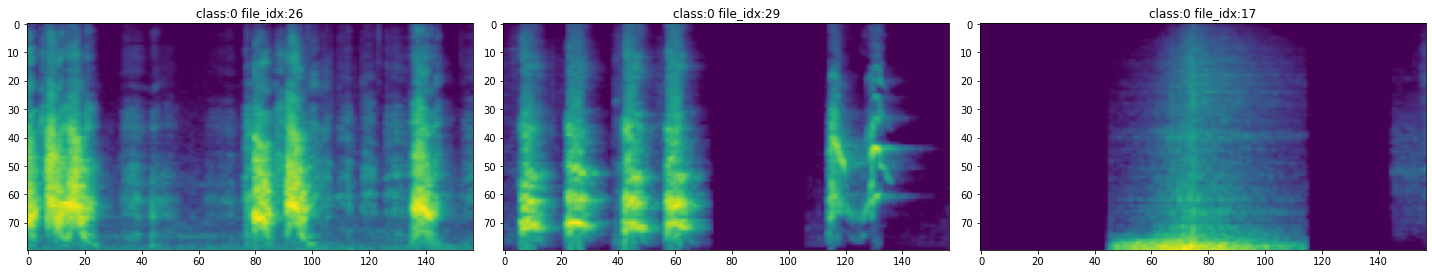

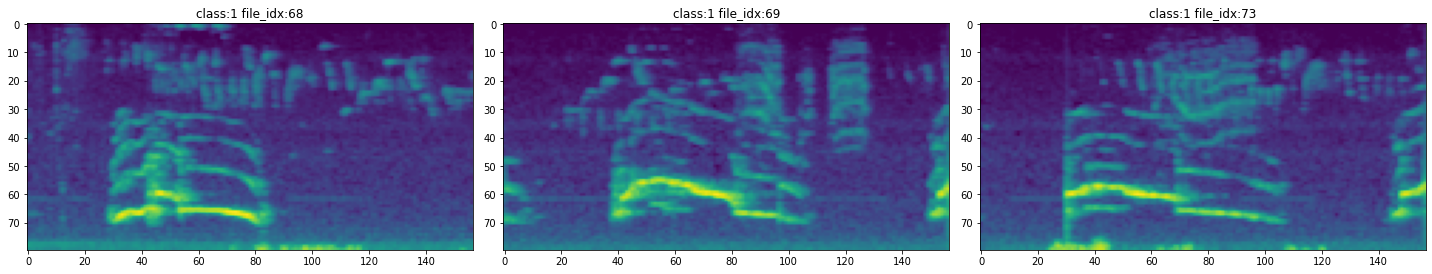

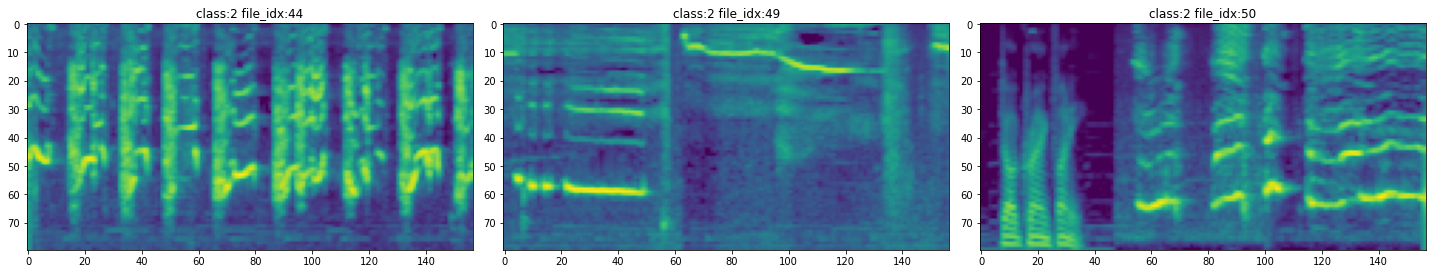

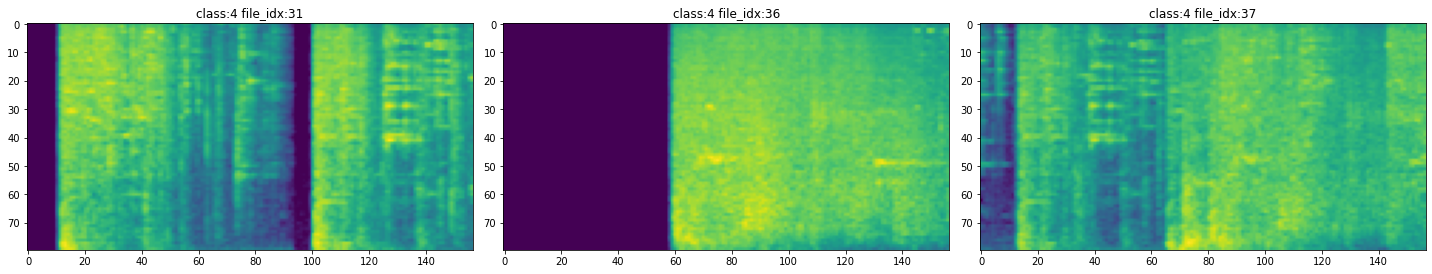

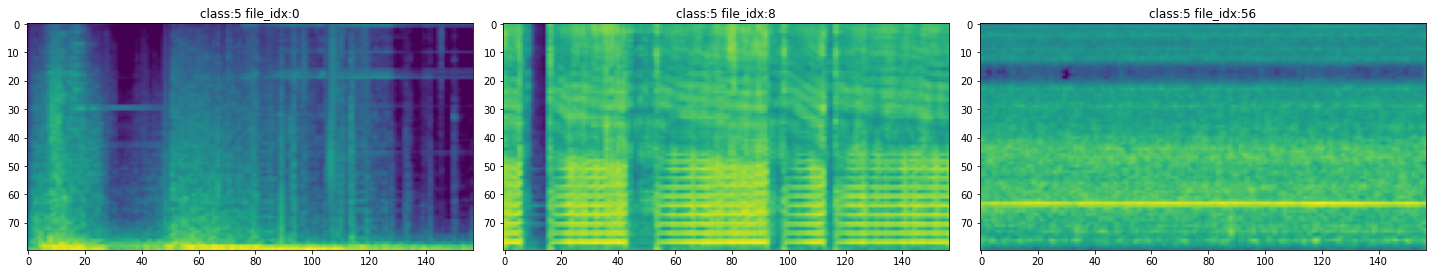

In [130]:
for class_name in sorted(extra_label_df.class_name.unique()):
    plot_feature_by_class_name(class_name,extra_X_train,extra_label_df)

In [131]:
X_train = torch.cat([X_train,extra_X_train],dim=0)
X_train.shape

torch.Size([1053, 1, 80, 157])

In [132]:
y_train = torch.cat([y_train,extra_y_train],dim=0)
y_train.shape

torch.Size([1053, 6])

In [133]:
X_valid.shape

torch.Size([240, 1, 80, 157])

In [134]:
y_valid.shape

torch.Size([240, 6])

#  create pytorch dataloader and save

In [135]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=32,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=32,num_workers=4)

In [136]:
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([32, 1, 80, 157]) cpu
torch.Size([32, 6]) cpu


# define model

In [137]:
import torch.hub
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
print(model)

CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


# model forward test

In [138]:
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

torch.Size([32, 1, 80, 157]) torch.Size([32, 6])


torch.Size([32, 6])

# def train loop

In [139]:
from sklearn.metrics import accuracy_score

def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).argmax(dim=1).detach().cpu().numpy()
    y = y.argmax(dim=1).detach().cpu().numpy()
    return accuracy_score(y,y_hat)
    #return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
                print('有進步')
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

  1%|          | 1/100 [00:06<10:37,  6.44s/it]

epoch:0 train_loss:0.6525 valid_loss:0.5944 train_auc:0.2444 valid_auc:0.2383
有進步
epoch:1 train_loss:0.5580 valid_loss:0.5218 train_auc:0.3420 valid_auc:0.3008
有進步


  3%|▎         | 3/100 [00:18<09:49,  6.08s/it]

epoch:2 train_loss:0.4994 valid_loss:0.4743 train_auc:0.4243 valid_auc:0.3359
有進步


  4%|▍         | 4/100 [00:25<10:32,  6.59s/it]

epoch:3 train_loss:0.4602 valid_loss:0.4397 train_auc:0.4820 valid_auc:0.4336
有進步


  5%|▌         | 5/100 [00:32<10:19,  6.52s/it]

epoch:4 train_loss:0.4314 valid_loss:0.4130 train_auc:0.5200 valid_auc:0.4961
有進步


  6%|▌         | 6/100 [00:38<10:05,  6.44s/it]

epoch:5 train_loss:0.4085 valid_loss:0.3896 train_auc:0.5598 valid_auc:0.5859
有進步


  7%|▋         | 7/100 [00:44<09:51,  6.36s/it]

epoch:6 train_loss:0.3891 valid_loss:0.3672 train_auc:0.5902 valid_auc:0.6172
有進步


  8%|▊         | 8/100 [00:50<09:37,  6.28s/it]

epoch:7 train_loss:0.3717 valid_loss:0.3453 train_auc:0.6139 valid_auc:0.6484
有進步


  9%|▉         | 9/100 [00:56<09:26,  6.22s/it]

epoch:8 train_loss:0.3559 valid_loss:0.3235 train_auc:0.6366 valid_auc:0.6875
有進步


 10%|█         | 10/100 [01:02<09:15,  6.18s/it]

epoch:9 train_loss:0.3417 valid_loss:0.3043 train_auc:0.6603 valid_auc:0.7188
有進步


 11%|█         | 11/100 [01:09<09:09,  6.18s/it]

epoch:10 train_loss:0.3290 valid_loss:0.2873 train_auc:0.6772 valid_auc:0.7344
有進步


 12%|█▏        | 12/100 [01:15<09:05,  6.20s/it]

epoch:11 train_loss:0.3177 valid_loss:0.2730 train_auc:0.6858 valid_auc:0.7344
有進步


 13%|█▎        | 13/100 [01:21<08:58,  6.19s/it]

epoch:12 train_loss:0.3077 valid_loss:0.2613 train_auc:0.6972 valid_auc:0.7344
有進步
epoch:13 train_loss:0.2988 valid_loss:0.2532 train_auc:0.7000 valid_auc:0.7422
有進步


 15%|█▌        | 15/100 [01:33<08:36,  6.08s/it]

epoch:14 train_loss:0.2907 valid_loss:0.2463 train_auc:0.7057 valid_auc:0.7539
有進步


 16%|█▌        | 16/100 [01:39<08:27,  6.05s/it]

epoch:15 train_loss:0.2831 valid_loss:0.2382 train_auc:0.7142 valid_auc:0.7461
有進步


 17%|█▋        | 17/100 [01:45<08:24,  6.08s/it]

epoch:16 train_loss:0.2761 valid_loss:0.2308 train_auc:0.7237 valid_auc:0.7773
有進步
epoch:17 train_loss:0.2697 valid_loss:0.2256 train_auc:0.7246 valid_auc:0.7969
有進步


 19%|█▉        | 19/100 [01:57<08:10,  6.05s/it]

epoch:18 train_loss:0.2637 valid_loss:0.2209 train_auc:0.7302 valid_auc:0.8242
有進步


 20%|██        | 20/100 [02:03<08:01,  6.01s/it]

epoch:19 train_loss:0.2581 valid_loss:0.2150 train_auc:0.7378 valid_auc:0.8320
有進步


 21%|██        | 21/100 [02:09<07:58,  6.05s/it]

epoch:20 train_loss:0.2527 valid_loss:0.2115 train_auc:0.7407 valid_auc:0.8203
有進步


 22%|██▏       | 22/100 [02:15<07:53,  6.07s/it]

epoch:21 train_loss:0.2476 valid_loss:0.2068 train_auc:0.7435 valid_auc:0.8125
有進步


 23%|██▎       | 23/100 [02:21<07:45,  6.04s/it]

epoch:22 train_loss:0.2426 valid_loss:0.2019 train_auc:0.7530 valid_auc:0.8164
有進步


 24%|██▍       | 24/100 [02:28<08:05,  6.39s/it]

epoch:23 train_loss:0.2379 valid_loss:0.2002 train_auc:0.7577 valid_auc:0.8125
有進步


 25%|██▌       | 25/100 [02:35<07:52,  6.30s/it]

epoch:24 train_loss:0.2333 valid_loss:0.1953 train_auc:0.7710 valid_auc:0.8359
有進步


 26%|██▌       | 26/100 [02:41<07:47,  6.32s/it]

epoch:25 train_loss:0.2288 valid_loss:0.1932 train_auc:0.7776 valid_auc:0.8242
有進步


 27%|██▋       | 27/100 [02:47<07:39,  6.29s/it]

epoch:26 train_loss:0.2246 valid_loss:0.1905 train_auc:0.7804 valid_auc:0.8281
有進步


 28%|██▊       | 28/100 [02:53<07:25,  6.19s/it]

epoch:27 train_loss:0.2203 valid_loss:0.1897 train_auc:0.7862 valid_auc:0.8359
有進步
epoch:28 train_loss:0.2163 valid_loss:0.1854 train_auc:0.7948 valid_auc:0.8398
有進步


 30%|███       | 30/100 [03:05<07:10,  6.14s/it]

epoch:29 train_loss:0.2121 valid_loss:0.1860 train_auc:0.8015 valid_auc:0.8242


 31%|███       | 31/100 [03:11<07:00,  6.10s/it]

epoch:30 train_loss:0.2084 valid_loss:0.1798 train_auc:0.8034 valid_auc:0.8398
有進步


 32%|███▏      | 32/100 [03:17<06:50,  6.04s/it]

epoch:31 train_loss:0.2044 valid_loss:0.1852 train_auc:0.8062 valid_auc:0.8164


 33%|███▎      | 33/100 [03:23<06:42,  6.00s/it]

epoch:32 train_loss:0.2010 valid_loss:0.1771 train_auc:0.8100 valid_auc:0.8320
有進步


 34%|███▍      | 34/100 [03:29<06:39,  6.05s/it]

epoch:33 train_loss:0.1970 valid_loss:0.1799 train_auc:0.8139 valid_auc:0.8281


 35%|███▌      | 35/100 [03:35<06:32,  6.04s/it]

epoch:34 train_loss:0.1936 valid_loss:0.1743 train_auc:0.8196 valid_auc:0.8320
有進步


 36%|███▌      | 36/100 [03:41<06:26,  6.03s/it]

epoch:35 train_loss:0.1900 valid_loss:0.1761 train_auc:0.8205 valid_auc:0.8281
epoch:36 train_loss:0.1868 valid_loss:0.1707 train_auc:0.8262 valid_auc:0.8438
有進步


 38%|███▊      | 38/100 [03:53<06:14,  6.04s/it]

epoch:37 train_loss:0.1835 valid_loss:0.1716 train_auc:0.8328 valid_auc:0.8281


 39%|███▉      | 39/100 [04:00<06:09,  6.05s/it]

epoch:38 train_loss:0.1804 valid_loss:0.1681 train_auc:0.8366 valid_auc:0.8555
有進步


 40%|████      | 40/100 [04:05<06:00,  6.01s/it]

epoch:39 train_loss:0.1771 valid_loss:0.1652 train_auc:0.8385 valid_auc:0.8516
有進步


 41%|████      | 41/100 [04:12<05:56,  6.05s/it]

epoch:40 train_loss:0.1741 valid_loss:0.1632 train_auc:0.8461 valid_auc:0.8594
有進步


 42%|████▏     | 42/100 [04:18<05:49,  6.02s/it]

epoch:41 train_loss:0.1714 valid_loss:0.1597 train_auc:0.8491 valid_auc:0.8711
有進步
epoch:42 train_loss:0.1682 valid_loss:0.1544 train_auc:0.8519 valid_auc:0.8555
有進步


 44%|████▍     | 44/100 [04:31<06:02,  6.46s/it]

epoch:43 train_loss:0.1648 valid_loss:0.1503 train_auc:0.8567 valid_auc:0.8633
有進步


 45%|████▌     | 45/100 [04:37<05:52,  6.41s/it]

epoch:44 train_loss:0.1615 valid_loss:0.1499 train_auc:0.8595 valid_auc:0.8672
有進步


 46%|████▌     | 46/100 [04:44<05:41,  6.33s/it]

epoch:45 train_loss:0.1580 valid_loss:0.1511 train_auc:0.8644 valid_auc:0.8594


 47%|████▋     | 47/100 [04:50<05:31,  6.25s/it]

epoch:46 train_loss:0.1548 valid_loss:0.1517 train_auc:0.8692 valid_auc:0.8555


 48%|████▊     | 48/100 [04:56<05:25,  6.25s/it]

epoch:47 train_loss:0.1512 valid_loss:0.1562 train_auc:0.8692 valid_auc:0.8477


 49%|████▉     | 49/100 [05:02<05:16,  6.20s/it]

epoch:48 train_loss:0.1480 valid_loss:0.1547 train_auc:0.8749 valid_auc:0.8477


 50%|█████     | 50/100 [05:08<05:12,  6.24s/it]

epoch:49 train_loss:0.1448 valid_loss:0.1539 train_auc:0.8834 valid_auc:0.8438


 51%|█████     | 51/100 [05:14<05:02,  6.18s/it]

epoch:50 train_loss:0.1416 valid_loss:0.1553 train_auc:0.8853 valid_auc:0.8438


 52%|█████▏    | 52/100 [05:20<04:54,  6.13s/it]

epoch:51 train_loss:0.1389 valid_loss:0.1604 train_auc:0.8959 valid_auc:0.8203


 53%|█████▎    | 53/100 [05:26<04:47,  6.11s/it]

epoch:52 train_loss:0.1358 valid_loss:0.1616 train_auc:0.8978 valid_auc:0.8086


 54%|█████▍    | 54/100 [05:32<04:38,  6.05s/it]

epoch:53 train_loss:0.1331 valid_loss:0.1575 train_auc:0.8969 valid_auc:0.8320


 55%|█████▌    | 55/100 [05:38<04:31,  6.03s/it]

epoch:54 train_loss:0.1301 valid_loss:0.1611 train_auc:0.9045 valid_auc:0.8125


 56%|█████▌    | 56/100 [05:44<04:26,  6.05s/it]

epoch:55 train_loss:0.1276 valid_loss:0.1554 train_auc:0.9045 valid_auc:0.8203


 57%|█████▋    | 57/100 [05:50<04:17,  5.98s/it]

epoch:56 train_loss:0.1247 valid_loss:0.1625 train_auc:0.9083 valid_auc:0.8047


 58%|█████▊    | 58/100 [05:56<04:11,  5.98s/it]

epoch:57 train_loss:0.1229 valid_loss:0.1606 train_auc:0.9140 valid_auc:0.8086


 59%|█████▉    | 59/100 [06:02<04:06,  6.00s/it]

epoch:58 train_loss:0.1201 valid_loss:0.1679 train_auc:0.9102 valid_auc:0.7969


 60%|██████    | 60/100 [06:08<04:01,  6.04s/it]

epoch:59 train_loss:0.1173 valid_loss:0.1585 train_auc:0.9168 valid_auc:0.8086


 61%|██████    | 61/100 [06:14<03:53,  5.98s/it]

epoch:60 train_loss:0.1152 valid_loss:0.1620 train_auc:0.9178 valid_auc:0.7969


 62%|██████▏   | 62/100 [06:20<03:47,  5.99s/it]

epoch:61 train_loss:0.1126 valid_loss:0.1665 train_auc:0.9235 valid_auc:0.7812


 63%|██████▎   | 63/100 [06:27<03:47,  6.15s/it]

epoch:62 train_loss:0.1098 valid_loss:0.1653 train_auc:0.9320 valid_auc:0.7773


 64%|██████▍   | 64/100 [06:34<03:54,  6.50s/it]

epoch:63 train_loss:0.1081 valid_loss:0.1565 train_auc:0.9301 valid_auc:0.8086


 65%|██████▌   | 65/100 [06:40<03:45,  6.43s/it]

epoch:64 train_loss:0.1064 valid_loss:0.1839 train_auc:0.9310 valid_auc:0.7539


 66%|██████▌   | 66/100 [06:46<03:34,  6.32s/it]

epoch:65 train_loss:0.1054 valid_loss:0.1427 train_auc:0.9320 valid_auc:0.8516
有進步


 67%|██████▋   | 67/100 [06:52<03:25,  6.21s/it]

epoch:66 train_loss:0.1025 valid_loss:0.1601 train_auc:0.9367 valid_auc:0.8008


 68%|██████▊   | 68/100 [06:58<03:15,  6.12s/it]

epoch:67 train_loss:0.1008 valid_loss:0.1372 train_auc:0.9405 valid_auc:0.8633
有進步


 69%|██████▉   | 69/100 [07:04<03:09,  6.12s/it]

epoch:68 train_loss:0.0982 valid_loss:0.1576 train_auc:0.9405 valid_auc:0.8242


 70%|███████   | 70/100 [07:10<03:01,  6.06s/it]

epoch:69 train_loss:0.0967 valid_loss:0.1504 train_auc:0.9433 valid_auc:0.8320


 71%|███████   | 71/100 [07:16<02:56,  6.09s/it]

epoch:70 train_loss:0.0949 valid_loss:0.1554 train_auc:0.9433 valid_auc:0.8164


 72%|███████▏  | 72/100 [07:23<02:50,  6.10s/it]

epoch:71 train_loss:0.0931 valid_loss:0.1617 train_auc:0.9452 valid_auc:0.8008
epoch:72 train_loss:0.0912 valid_loss:0.1520 train_auc:0.9452 valid_auc:0.8281


 74%|███████▍  | 74/100 [07:35<02:40,  6.17s/it]

epoch:73 train_loss:0.0892 valid_loss:0.1527 train_auc:0.9509 valid_auc:0.8242


 75%|███████▌  | 75/100 [07:41<02:33,  6.14s/it]

epoch:74 train_loss:0.0870 valid_loss:0.1471 train_auc:0.9528 valid_auc:0.8281


 76%|███████▌  | 76/100 [07:47<02:25,  6.05s/it]

epoch:75 train_loss:0.0855 valid_loss:0.1463 train_auc:0.9547 valid_auc:0.8359


 77%|███████▋  | 77/100 [07:53<02:18,  6.03s/it]

epoch:76 train_loss:0.0838 valid_loss:0.1369 train_auc:0.9604 valid_auc:0.8633
有進步


 78%|███████▊  | 78/100 [07:59<02:13,  6.05s/it]

epoch:77 train_loss:0.0812 valid_loss:0.1481 train_auc:0.9595 valid_auc:0.8516


 79%|███████▉  | 79/100 [08:05<02:07,  6.05s/it]

epoch:78 train_loss:0.0797 valid_loss:0.1415 train_auc:0.9594 valid_auc:0.8516


 80%|████████  | 80/100 [08:11<02:00,  6.05s/it]

epoch:79 train_loss:0.0770 valid_loss:0.1394 train_auc:0.9651 valid_auc:0.8555


 81%|████████  | 81/100 [08:17<01:54,  6.01s/it]

epoch:80 train_loss:0.0749 valid_loss:0.1572 train_auc:0.9681 valid_auc:0.8281


 82%|████████▏ | 82/100 [08:23<01:48,  6.00s/it]

epoch:81 train_loss:0.0740 valid_loss:0.1547 train_auc:0.9690 valid_auc:0.8477


 83%|████████▎ | 83/100 [08:29<01:42,  6.05s/it]

epoch:82 train_loss:0.0724 valid_loss:0.1560 train_auc:0.9682 valid_auc:0.8281


 84%|████████▍ | 84/100 [08:37<01:43,  6.49s/it]

epoch:83 train_loss:0.0701 valid_loss:0.1511 train_auc:0.9690 valid_auc:0.8555


 85%|████████▌ | 85/100 [08:43<01:35,  6.34s/it]

epoch:84 train_loss:0.0680 valid_loss:0.1550 train_auc:0.9690 valid_auc:0.8320


 86%|████████▌ | 86/100 [08:49<01:28,  6.30s/it]

epoch:85 train_loss:0.0671 valid_loss:0.1559 train_auc:0.9703 valid_auc:0.8359


 87%|████████▋ | 87/100 [08:55<01:21,  6.27s/it]

epoch:86 train_loss:0.0647 valid_loss:0.1570 train_auc:0.9721 valid_auc:0.8281


 88%|████████▊ | 88/100 [09:02<01:15,  6.28s/it]

epoch:87 train_loss:0.0631 valid_loss:0.1479 train_auc:0.9731 valid_auc:0.8477


 89%|████████▉ | 89/100 [09:08<01:08,  6.24s/it]

epoch:88 train_loss:0.0630 valid_loss:0.1817 train_auc:0.9721 valid_auc:0.7852


 90%|█████████ | 90/100 [09:14<01:01,  6.18s/it]

epoch:89 train_loss:0.0635 valid_loss:0.1676 train_auc:0.9674 valid_auc:0.8125


 91%|█████████ | 91/100 [09:20<00:55,  6.12s/it]

epoch:90 train_loss:0.0644 valid_loss:0.1541 train_auc:0.9741 valid_auc:0.8438


 92%|█████████▏| 92/100 [09:26<00:48,  6.10s/it]

epoch:91 train_loss:0.0608 valid_loss:0.1586 train_auc:0.9683 valid_auc:0.8281


 93%|█████████▎| 93/100 [09:32<00:43,  6.17s/it]

epoch:92 train_loss:0.0616 valid_loss:0.2098 train_auc:0.9703 valid_auc:0.7578


 94%|█████████▍| 94/100 [09:38<00:37,  6.21s/it]

epoch:93 train_loss:0.0618 valid_loss:0.1742 train_auc:0.9704 valid_auc:0.7969


 95%|█████████▌| 95/100 [09:44<00:30,  6.11s/it]

epoch:94 train_loss:0.0590 valid_loss:0.2028 train_auc:0.9731 valid_auc:0.7773


 96%|█████████▌| 96/100 [09:51<00:24,  6.17s/it]

epoch:95 train_loss:0.0586 valid_loss:0.1572 train_auc:0.9703 valid_auc:0.8203


 97%|█████████▋| 97/100 [09:57<00:18,  6.12s/it]

epoch:96 train_loss:0.0629 valid_loss:0.1914 train_auc:0.9684 valid_auc:0.8125


 98%|█████████▊| 98/100 [10:03<00:12,  6.08s/it]

epoch:97 train_loss:0.0595 valid_loss:0.1615 train_auc:0.9675 valid_auc:0.8320


 99%|█████████▉| 99/100 [10:09<00:06,  6.08s/it]

epoch:98 train_loss:0.0581 valid_loss:0.2171 train_auc:0.9721 valid_auc:0.7852


100%|██████████| 100/100 [10:15<00:00,  6.15s/it]

epoch:99 train_loss:0.0587 valid_loss:0.1889 train_auc:0.9675 valid_auc:0.8164


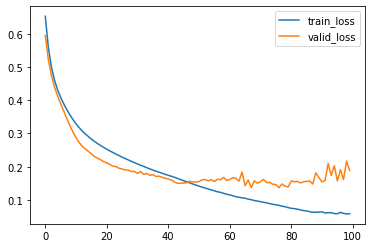

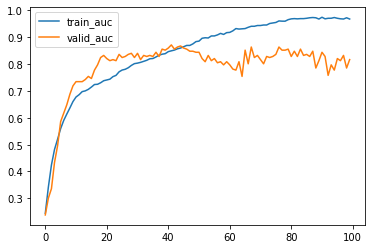

In [140]:
device = 'cuda:0'
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=100,log_interval=1,device=device)

In [141]:
torch.save(model.state_dict(),'senet20_wu_add_data_seed42.pt')

In [142]:
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.eval()
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


In [143]:
model.load_state_dict(torch.load('senet20_wu_add_data_seed42.pt'))

<All keys matched successfully>

# model infernce test

In [144]:
from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

In [145]:
cm,acc = plot_confusion_matrix(model.to(device),train_iter)
print(acc)
cm

100%|██████████| 33/33 [00:02<00:00, 14.53it/s]

0.879392212725546


Barking  Howling  Crying  COSmoke  GlassBreaking  Electrics
0      158        4       7        2              2          7
1        4      140      15        0              0         11
2       10       25     147        4              4         14
3        0        0       1      154              1          5
4        1        0       0        0            155          2
5        1        0       3        0              4        172

In [146]:
cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
print(acc)
cm

100%|██████████| 8/8 [00:01<00:00,  5.99it/s]

0.8541666666666666


Barking  Howling  Crying  COSmoke  GlassBreaking  Electrics
0       29        0       1        2              0          0
1        4       33       3        1              2          1
2        5        6      36        1              0          3
3        0        0       0       35              0          0
4        0        0       0        0             37          1
5        2        1       0        1              1         35

# submit

In [147]:
print(X_test.shape[0])

10000


In [148]:
sample_submit = pd.read_csv('sample_submission.csv')
model = model.to('cuda:0')
model.eval()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Filename   Barking   Howling    Crying   COSmoke  GlassBreaking  \
0       public_00001 -3.450421 -3.847183 -3.635791 -4.469158      -3.280316   
1       public_00002 -3.534290 -4.423361 -3.333948 -3.680201      -4.309159   
2       public_00003  1.961792 -4.012313 -1.903188 -5.491640      -5.322916   
3       public_00004 -3.073799 -4.819983 -4.331708 -3.109063      -2.121310   
4       public_00005 -1.061751 -2.666986  0.954746 -5.429027      -5.570005   
...              ...       ...       ...       ...       ...            ...   
29995  private_19996  0.166600  0.166600  0.166600  0.166600       0.166600   
29996  private_19997  0.166600  0.166600  0.166600  0.166600       0.166600   
29997  private_19998  0.166600  0.166600  0.166600  0.166600       0.166600   
29998  private_19999  0.166600  0.166600  0.166600  0.166600       0.166600   
29999  private_20000  0.166600  0.166600  0.166600  0.166600       0.166600   

          Other  
0      1.890062  
1      2.143325  
2     -3.460190  
3      0.608956  
4     -3.437792  
...         ...  
29995  0.167000  
29996  0.167000  
29997  0.167000  
29998  0.167000  
29999  0.167000  

[30000 rows x 7 columns]

In [149]:
from scipy.special import softmax
a = softmax(sample_submit.iloc[:,1:].values,axis=1)
a

array([[4.70227028e-03, 3.16225068e-03, 3.90663231e-03, 1.69775846e-03,
        5.57421159e-03, 9.80956877e-01],
       [3.37598914e-03, 1.38765792e-03, 4.12485365e-03, 2.91764605e-03,
        1.55553478e-03, 9.86638318e-01],
       [9.71637045e-01, 2.47162928e-03, 2.03687525e-02, 5.63014913e-04,
        6.66493360e-04, 4.29306474e-03],
       ...,
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01]])

In [150]:
sample_submit.iloc[:,1:] = a
sample_submit

Filename   Barking   Howling    Crying   COSmoke  GlassBreaking  \
0       public_00001  0.004702  0.003162  0.003907  0.001698       0.005574   
1       public_00002  0.003376  0.001388  0.004125  0.002918       0.001556   
2       public_00003  0.971637  0.002472  0.020369  0.000563       0.000666   
3       public_00004  0.022335  0.003896  0.006349  0.021561       0.057897   
4       public_00005  0.113258  0.022747  0.850787  0.001437       0.001248   
...              ...       ...       ...       ...       ...            ...   
29995  private_19996  0.166656  0.166656  0.166656  0.166656       0.166656   
29996  private_19997  0.166656  0.166656  0.166656  0.166656       0.166656   
29997  private_19998  0.166656  0.166656  0.166656  0.166656       0.166656   
29998  private_19999  0.166656  0.166656  0.166656  0.166656       0.166656   
29999  private_20000  0.166656  0.166656  0.166656  0.166656       0.166656   

          Other  
0      0.980957  
1      0.986638  
2      0.004293  
3      0.887961  
4      0.010524  
...         ...  
29995  0.166722  
29996  0.166722  
29997  0.166722  
29998  0.166722  
29999  0.166722  

[30000 rows x 7 columns]

In [151]:
sample_submit.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [152]:
# save
sample_submit.to_csv('senet20_wu_add_data_seed42.csv',index=False)
print('done')

done
